In [1]:
# This is for compatibility with google colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401

Mounted at /content/drive
/content/drive/MyDrive/MultiOmicsIntegration/comp-401


In [2]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import json
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore', 'Solver terminated early.*')

In [3]:
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks


# KIPAN Subtyping

In [ ]:
datasets = {
            'rna': '../data/kipan/subtyping/RNASeq.csv',
            'cnv': '../data/kipan/subtyping/CNV.csv',
            'rppa': '../data/kipan/subtyping/RPPA.csv',
}

labels = '../data/kipan/subtyping/Clinical.csv'

In [ ]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (736, 20190)
cnv (736, 24776)
rppa (736, 202)


In [ ]:
!pip3 install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.5 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=d596d0f3dcfff0caa42f25c49bbf9a72c98e7a3dd291321f38e28d57659fcf07
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
import scanpy as sc
from scanpy.pp import highly_variable_genes
import anndata as an

In [ ]:
adata = {}

for modality in datasets:
  data[modality] = data[modality].dropna(axis=1)
  adata[modality] = an.AnnData(data[modality])

In [ ]:
sc.pp.highly_variable_genes(adata['rna'], n_top_genes=1000)

In [ ]:
sc.pp.highly_variable_genes(adata['cnv'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [ ]:
sc.pp.highly_variable_genes(adata['rppa'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


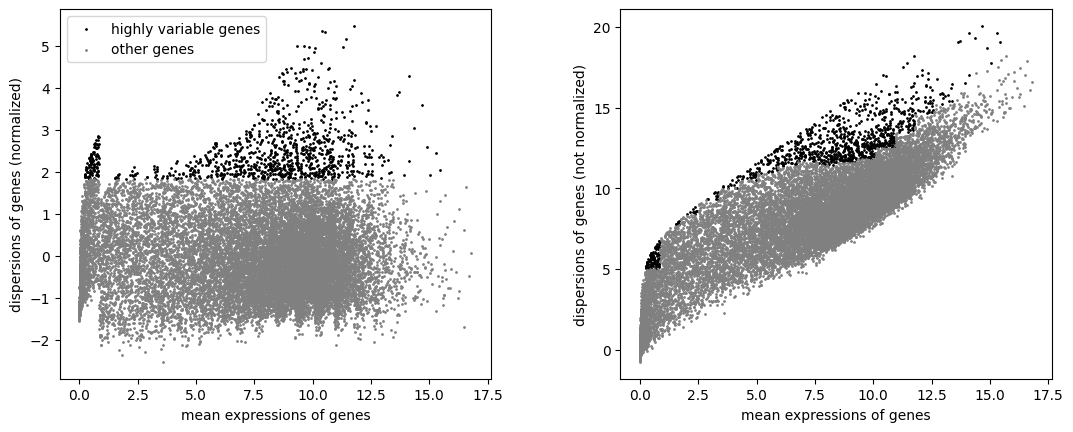

In [ ]:
sc.pl.highly_variable_genes(adata['rna'])

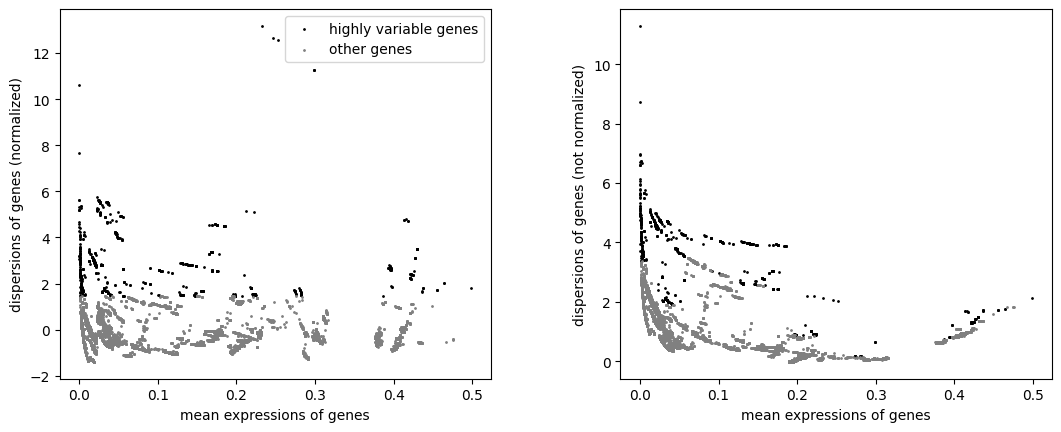

In [ ]:
sc.pl.highly_variable_genes(adata['cnv'])

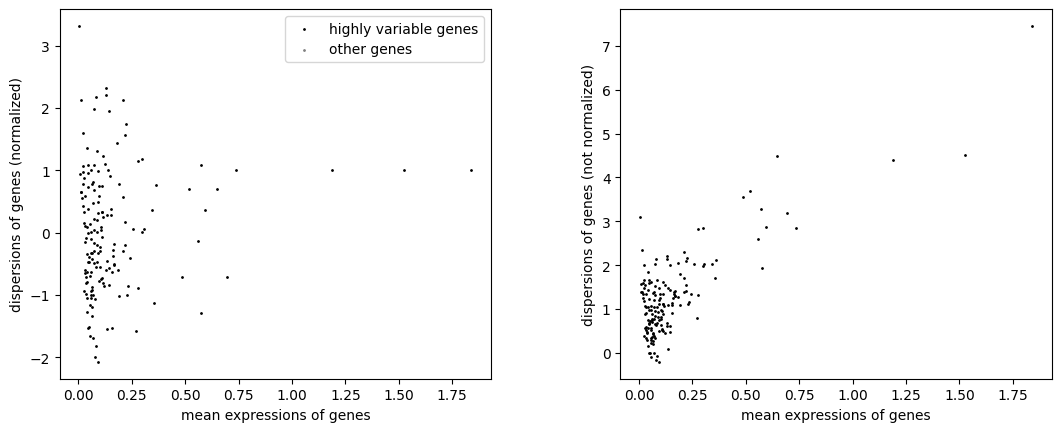

In [ ]:
sc.pl.highly_variable_genes(adata['rppa'])

In [ ]:
adata_new = {}

for modality in datasets:
  adata_new[modality] = adata[modality][:, adata[modality].var.highly_variable]
  sc.pp.scale(adata_new[modality], max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
adata_new

{'rna': AnnData object with n_obs × n_vars = 736 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'cnv': AnnData object with n_obs × n_vars = 736 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'rppa': AnnData object with n_obs × n_vars = 736 × 168
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg'}

In [ ]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in adata_new:
    X[modality] = adata_new[modality].to_df()
    print(modality, X[modality].shape)

rna (736, 1000)
cnv (736, 1000)
rppa (736, 168)


In [ ]:
subtypes['histological_type'].value_counts()

histological_type
kidneyclearcellrenalcarcinoma        467
kidneypapillaryrenalcellcarcinoma    206
kidneychromophobe                     63
Name: count, dtype: int64

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['histological_type'])
enc.inverse_transform([0, 1, 2])

array(['kidneychromophobe', 'kidneyclearcellrenalcarcinoma',
       'kidneypapillaryrenalcellcarcinoma'], dtype=object)

In [ ]:
new_subtypes = subtypes

In [ ]:
new_subtypes['histological_type_enc'] = enc.fit_transform(subtypes['histological_type'])

In [ ]:
new_subtypes

,histological_type,pathologic_stage,survival_time,status,histological_type_enc
SubjectID,,,,,
TCGA.KL.8324,kidneychromophobe,stageii,4676.0,0.0,0
TCGA.KL.8325,kidneychromophobe,stageii,725.0,1.0,0
TCGA.KL.8326,kidneychromophobe,stageiii,3322.0,0.0,0
TCGA.KL.8327,kidneychromophobe,stagei,4169.0,0.0,0
TCGA.KL.8328,kidneychromophobe,stageii,3127.0,0.0,0
...,...,...,...,...,...
TCGA.Y8.A897,kidneypapillaryrenalcellcarcinoma,stagei,549.0,0.0,2
TCGA.Y8.A8RY,kidneypapillaryrenalcellcarcinoma,stagei,769.0,0.0,2
TCGA.Y8.A8RZ,kidneypapillaryrenalcellcarcinoma,stagei,205.0,0.0,2


In [ ]:
new_subtypes['histological_type_enc'].to_csv('../data/kipan/subtyping/Clinical_enc.csv')

In [ ]:
import csv

filenames = {'rna': '../data/kipan/subtyping/RNASeq_clean.csv', 'cnv': '../data/kipan/subtyping/CNV_clean.csv', 'rppa': '../data/kipan/subtyping/RPPA_clean.csv'}

for modality in filenames:
  X[modality].to_csv(filenames[modality])

# KIPAN Staging

In [4]:
datasets = {
            'rna': '../data/kipan/staging/RNASeq.csv',
            'meth': '../data/kipan/staging/Methylation.csv',
            'rppa': '../data/kipan/staging/RPPA.csv',
}

labels = '../data/kipan/staging/Clinical.csv'

In [5]:
stages = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (558, 20190)
meth (558, 20116)
rppa (558, 202)


## Preprocessing

### Removing low-variance + null features

In [6]:
!pip3 install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=f1d920fee74edf314b90a110fc69f6d7c39642ca900f6f3fb114b485e5776e75
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [7]:
import scanpy as sc
from scanpy.pp import highly_variable_genes
import anndata as an

In [8]:
adata = {}

for modality in datasets:
  data[modality] = data[modality].dropna(axis=1)
  adata[modality] = an.AnnData(data[modality])

In [9]:
sc.pp.highly_variable_genes(adata['rna'], n_top_genes=1000)

In [10]:
sc.pp.highly_variable_genes(adata['meth'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [11]:
sc.pp.highly_variable_genes(adata['rppa'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


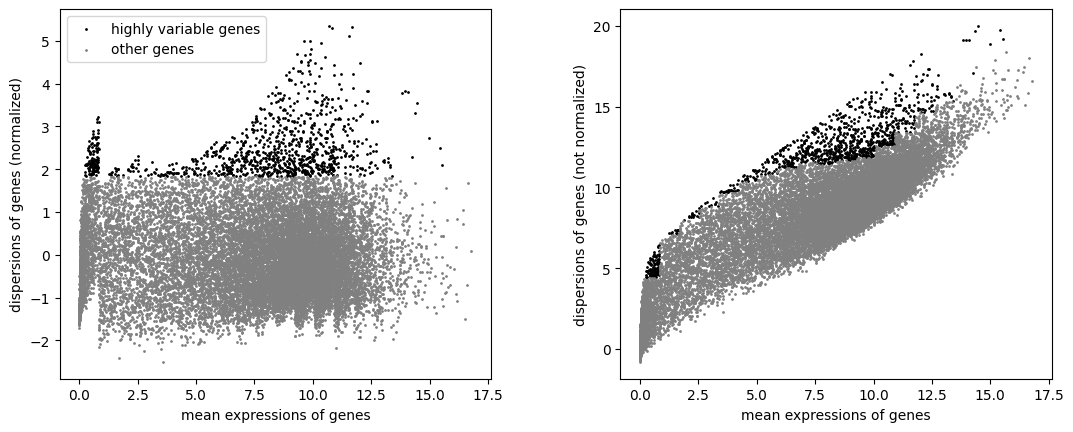

In [ ]:
sc.pl.highly_variable_genes(adata['rna'])

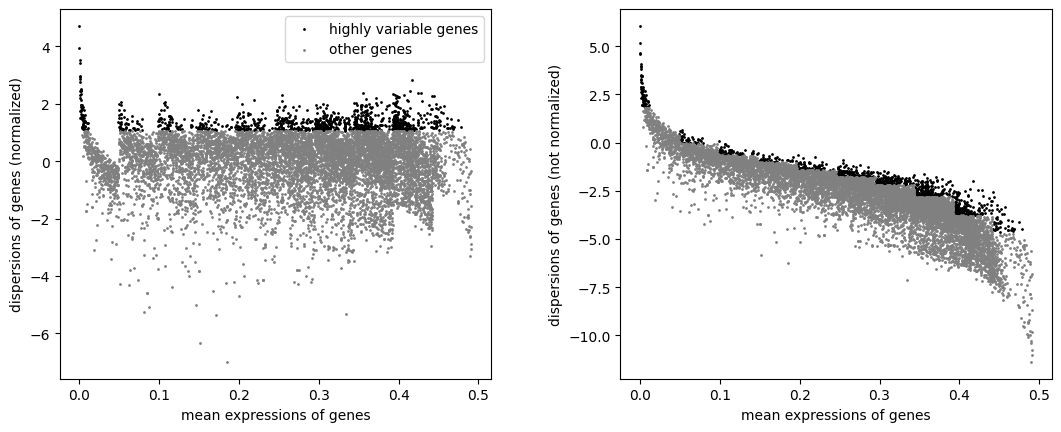

In [ ]:
sc.pl.highly_variable_genes(adata['meth'])

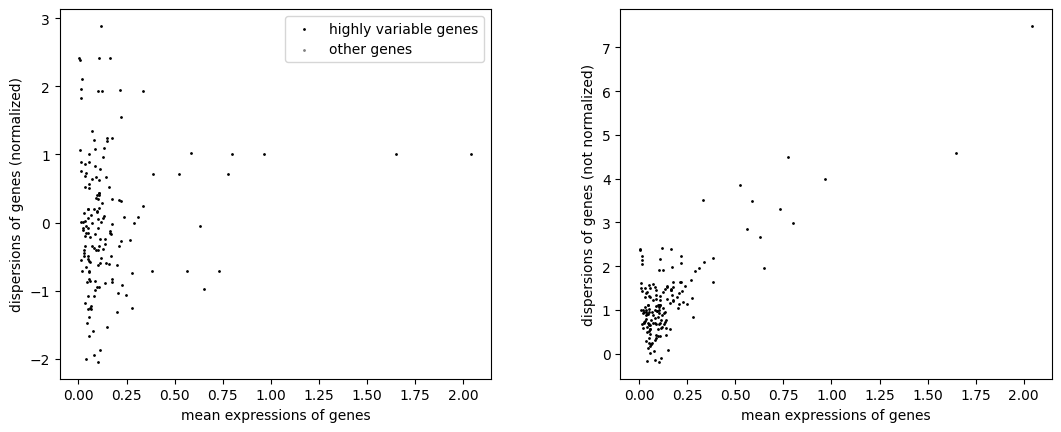

In [ ]:
sc.pl.highly_variable_genes(adata['rppa'])

In [ ]:
adata_new = {}

for modality in datasets:
  adata_new[modality] = adata[modality][:, adata[modality].var.highly_variable]
  sc.pp.scale(adata_new[modality], max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
adata_new

{'rna': AnnData object with n_obs × n_vars = 558 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'meth': AnnData object with n_obs × n_vars = 558 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'rppa': AnnData object with n_obs × n_vars = 558 × 168
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg'}

In [ ]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in adata_new:
    X[modality] = adata_new[modality].to_df()
    print(modality, X[modality].shape)

rna (558, 1000)
meth (558, 1000)
rppa (558, 168)


In [19]:
stages = pd.read_csv(labels, index_col=0)
stages['pathologic_stage'].value_counts()

pathologic_stage
stagei      280
stageiii    129
stageiv      79
stageii      70
Name: count, dtype: int64

In [14]:
enc = LabelEncoder()
y = enc.fit_transform(stages['pathologic_stage'])
enc.inverse_transform([0, 1, 2, 3])

array(['stagei', 'stageii', 'stageiii', 'stageiv'], dtype=object)

In [15]:
# Assuming your array is named 'arr'
y = np.where(np.logical_or(y == 0, y == 1), 0, 1)

In [ ]:
unique, counts = np.unique(y, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 350],
       [  1, 208]])

In [ ]:
import csv

filenames = {'rna': '../data/kipan/staging/RNASeq_clean.csv', 'meth': '../data/kipan/staging/meth_clean.csv', 'rppa': '../data/kipan/staging/RPPA_clean.csv'}

for modality in filenames:
  X[modality].to_csv(filenames[modality])

In [26]:
new_stages = stages
new_stages['stage_enc'] = enc.fit_transform(stages['pathologic_stage'])
new_stages['stage_enc'] = np.where(np.logical_or(new_stages['stage_enc'] == 0, new_stages['stage_enc'] == 1), 0, 1)

In [27]:
new_stages['stage_enc'].value_counts()

stage_enc
0    350
1    208
Name: count, dtype: int64

In [28]:
new_stages['stage_enc'].to_csv('../data/kipan/staging/Clinical_enc.csv')

# BRCA

In [29]:
datasets = {
            'rna': '../data/breast/RNASeq.csv',
            'mirna': '../data/breast/miRNASeq.csv',
            'meth': '../data/breast/Methylation.csv',
}

labels = '../data/breast/Clinical.csv'

In [30]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (430, 20155)
mirna (430, 823)
meth (430, 20106)


In [ ]:
adata = {}

for modality in datasets:
  data[modality] = data[modality].dropna(axis=1)
  adata[modality] = an.AnnData(data[modality])

In [ ]:
sc.pp.highly_variable_genes(adata['rna'], n_top_genes=1000)

In [ ]:
sc.pp.highly_variable_genes(adata['mirna'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


In [ ]:
sc.pp.highly_variable_genes(adata['meth'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [ ]:
adata_new = {}

for modality in datasets:
  adata_new[modality] = adata[modality][:, adata[modality].var.highly_variable]
  sc.pp.scale(adata_new[modality], max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
adata_new

{'rna': AnnData object with n_obs × n_vars = 430 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'mirna': AnnData object with n_obs × n_vars = 430 × 823
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'meth': AnnData object with n_obs × n_vars = 430 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg'}

In [ ]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in adata_new:
    X[modality] = adata_new[modality].to_df()
    print(modality, X[modality].shape)

rna (430, 1000)
mirna (430, 823)
meth (430, 1000)


In [ ]:
subtypes['PAM50'].value_counts()

PAM50
LumA     229
LumB     100
Basal     71
Her2      30
Name: count, dtype: int64

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['PAM50'])
enc.inverse_transform([0, 1, 2])

array(['Basal', 'Her2', 'LumA'], dtype=object)

In [ ]:
import csv

filenames = {'rna': '../data/breast/RNASeq_clean.csv', 'mirna': '../data/breast/miRNASeq_clean.csv', 'meth': '../data/breast/Methylation_clean.csv'}

for modality in filenames:
  X[modality].to_csv(filenames[modality])

In [31]:
new_subtypes = subtypes
new_subtypes['PAM50'] = enc.fit_transform(subtypes['PAM50'])

In [32]:
new_subtypes

,PAM50,survival_time,status
SubjectID,,,
TCGA.A1.A0SF,2,1463.0,0.0
TCGA.A1.A0SI,3,635.0,0.0
TCGA.A1.A0SN,3,1196.0,0.0
TCGA.A1.A0SQ,2,554.0,0.0
TCGA.A2.A0CK,2,4159.0,0.0
...,...,...,...
TCGA.LQ.A4E4,2,849.0,0.0
TCGA.OL.A66H,2,812.0,0.0
TCGA.OL.A66I,0,714.0,0.0


In [33]:
new_subtypes['PAM50'].to_csv('../data/breast/Clinical_enc.csv')